In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pylcp as lcp
import scipy.constants as cts
from pylcp.common import progressBar
# from Animator import Animator
from matplotlib import rc
from IPython.display import HTML

# Define the Units

Units are like below.

$$
\begin{align*}
x_0 &= \frac{\hbar \Gamma}{\mu_B B'} \\
    t_0 &= \frac{k x_0}{\Gamma} \\
    m_0 &= \hbar k^2 t_0
\end{align*}
$$

In [2]:
rb = lcp.atom('87Rb')
gamma = rb.state[2].gamma

In [3]:
x0 = cts.hbar*gamma/(cts.value('Bohr magneton')*15*1e-4) #Note that AMO use cm more than m, G more than T
k = rb.transition[1].k * 2*np.pi # cm^{-1}
t0 = k*x0/gamma
kbar = k*x0


mass = rb.mass/(cts.hbar*(k*1e2)**2*t0)

print(x0, k, kbar,gamma, t0, mass)

0.28896123233790394 80528.75481555492 23269.688230139665 38117309.832741246 0.0006104756167800681 0.034966307141434304


In [4]:
rb.transition[1].k

12816.549389930837

In [5]:
delta = -1.5
alpha = 1
s = 1

laserBeams = lcp.laserBeams([
    {'kvec':np.array([0., 0., 1]), 'pol':np.array([0., 0., 1.]), 's':s, 'delta':delta},
    {'kvec':np.array([0., 0., -1]), 'pol':np.array([1., 0., 0.]), 's':s, 'delta':delta}],
    beam_type=lcp.infinitePlaneWaveBeam)

magField = lcp.quadrupoleMagneticField(alpha)
# magField = lambda R : np.array([np.sign(R[0])*R[0]**2,np.sign(R[1])*R[1]**2,np.sign(R[2])*R[2]**2])

# Use the heuristic equation
heuristiceq = lcp.heuristiceq(laserBeams, magField, gamma=1, mass=mass)

# Or use the rate equation
Hg, muqg = lcp.hamiltonians.singleF(F=0, muB=1)
He, muqe = lcp.hamiltonians.singleF(F=1, muB=1)

dq = lcp.hamiltonians.dqij_two_bare_hyperfine(0, 1)

hamiltonian = lcp.hamiltonian(Hg, He, muqg, muqe, dq, mass=mass)

rateeq = lcp.rateeq(laserBeams, magField, hamiltonian, include_mag_forces=False)

In [6]:
# Define the position and velocity we want to sweep.

dz = 0.1
dv = 0.1
z = np.arange(-20, 20+dz, dz)
v = np.arange(-20, 20+dv, dv)

Z, V = np.meshgrid(z, v)

Rfull = np.array([np.zeros(Z.shape), np.zeros(Z.shape), Z])
Vfull = np.array([np.zeros(V.shape), np.zeros(V.shape), V])

heuristiceq.generate_force_profile([np.zeros(Z.shape), np.zeros(Z.shape), Z],
                           [np.zeros(V.shape), np.zeros(V.shape), V],
                           name='Fz', progress_bar=True);

Completed in 23.03 s.                                               


In [7]:
rateeq.generate_force_profile([np.zeros(Z.shape), np.zeros(Z.shape), Z],
                           [np.zeros(V.shape), np.zeros(V.shape), V],
                           name='Fz', progress_bar=True);

Completed in 50.36 s.                                               


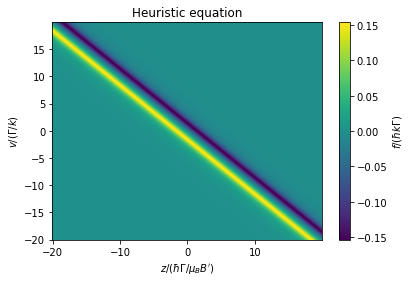

In [8]:
fig, ax = plt.subplots(1, 1)
plt.imshow(heuristiceq.profile['Fz'].F[2], origin='lower',
           extent=(np.amin(z)-dz/2, np.amax(z)-dz/2,
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$f/(\hbar k \Gamma)$')
ax.set_xlabel('$z/(\hbar \Gamma/\mu_B B\')$')
ax.set_ylabel('$v/(\Gamma/k)$')
ax.set_title('Heuristic equation')
fig.subplots_adjust(left=0.12,right=0.9)

fig.savefig('20210225_6.png')

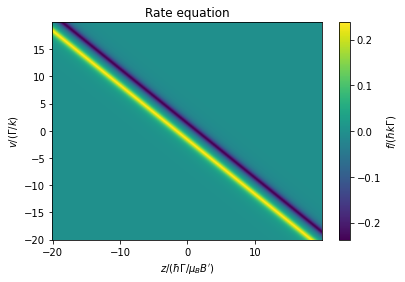

In [9]:
fig, ax = plt.subplots(1, 1)
plt.imshow(rateeq.profile['Fz'].F[2], origin='lower',
           extent=(np.amin(z)-dz/2, np.amax(z)-dz/2,
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$f/(\hbar k \Gamma)$')
ax.set_xlabel('$z/(\hbar \Gamma/\mu_B B\')$')
ax.set_ylabel('$v/(\Gamma/k)$')
ax.set_title('Rate equation')
fig.subplots_adjust(left=0.12,right=0.9)

fig.savefig('20210225_7.png')

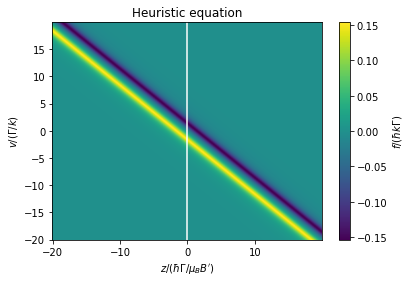

In [10]:
fig, ax = plt.subplots(1, 1)
plt.imshow(heuristiceq.profile['Fz'].F[2], origin='lower',
           extent=(np.amin(z)-dz/2, np.amax(z)-dz/2,
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$f/(\hbar k \Gamma)$')
ax.set_xlabel('$z/(\hbar \Gamma/\mu_B B\')$')
ax.set_ylabel('$v/(\Gamma/k)$')
ax.set_title('Heuristic equation')
fig.subplots_adjust(left=0.12,right=0.9)
ax.plot(np.zeros(v.shape)[:-2],v[:-2],'w-')

fig.savefig('20210225_3.png')

In [11]:
heuristiceq.generate_force_profile(np.zeros((3,)+v.shape),
                           [np.zeros(v.shape), np.zeros(v.shape), v],
                           name='Fz with z=0', progress_bar=True);

Completed in 0.06 s.                                              


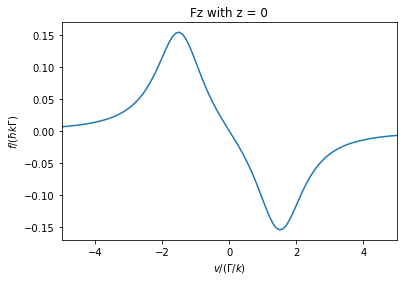

In [12]:
fig,ax = plt.subplots(1,1)
ax.plot(v, heuristiceq.profile['Fz with z=0'].F[2])
ax.set_xlabel('$v/(\Gamma/k)$')
ax.set_ylabel('$f/(\hbar k \Gamma)$')
ax.set_title('Fz with z = 0')
ax.set_xlim([-5,5])

fig.savefig('20210225_4.png')

In [13]:
# See solve_ivp documentation for event function discussion:
def captured_condition(t, y, threshold=1e-5):
    if(y[-4]<threshold and y[-1]<1e-3):
        val = -1.
    else:
        val = 1.

    return val

def lost_condition(t, y, threshold=1e-5):
    if y[-1]>20.:
        val = -1.
    else:
        val = 1.

    return val

captured_condition.terminal=True
lost_condition.terminal=True

In [14]:
v0s = np.arange(1, 16, 1)
t_eval = np.linspace(0.,100.,501)
sols_heur = list()
sols_rate = list()
for v0 in v0s:
    heuristiceq.set_initial_position_and_velocity(np.array([0.,0.,z[0]]),np.array([0.,0.,v0]))
    rateeq.set_initial_position_and_velocity(np.array([0.,0.,z[0]]),np.array([0.,0.,v0]))
    rateeq.set_initial_pop(np.array([1.,0.,0.,0.]))
    
    heuristiceq.evolve_motion([0.,100.],t_eval=t_eval,events = [captured_condition,lost_condition],max_step = 0.1,progress_bar = 1)
    rateeq.evolve_motion([0.,100.],t_eval=t_eval,events = [captured_condition,lost_condition],max_step = 0.1,progress_bar = 1)
    sols_heur.append(heuristiceq.sol)
    sols_rate.append(rateeq.sol)

Completed in 0.19 s.                                              
Completed in 0.36 s.                                              
Completed in 0.12 s.                                              
Completed in 0.23 s.                                              
Completed in 0.10 s.                                              
Completed in 0.18 s.                                              
Completed in 0.09 s.                                              
Completed in 0.16 s.                                              
Completed in 0.08 s.                                              
Completed in 0.14 s.                                              
Completed in 0.07 s.                                              
Completed in 0.13 s.                                              
Completed in 0.07 s.                                              
Completed in 0.13 s.                                              
Completed in 0.05 s.                                          

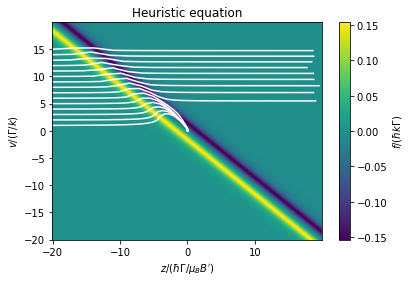

In [15]:
fig, ax = plt.subplots(1, 1)
plt.imshow(heuristiceq.profile['Fz'].F[2], origin='lower',
           extent=(np.amin(z)-dz/2, np.amax(z)-dz/2,
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$f/(\hbar k \Gamma)$')
ax.set_xlabel('$z/(\hbar \Gamma/\mu_B B\')$')
ax.set_ylabel('$v/(\Gamma/k)$')
ax.set_title('Heuristic equation')
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols_heur:
    ax.plot(sol.r[2],sol.v[2], 'w-')
    
fig.savefig('20210225_8.png')

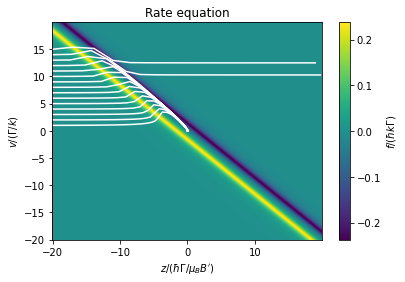

In [16]:
fig, ax = plt.subplots(1, 1)
plt.imshow(rateeq.profile['Fz'].F[2], origin='lower',
           extent=(np.amin(z)-dz/2, np.amax(z)-dz/2,
                   np.amin(v)-dv/2, np.amax(v)-dv/2),
           aspect='auto')
cb1 = plt.colorbar()
cb1.set_label('$f/(\hbar k \Gamma)$')
ax.set_xlabel('$z/(\hbar \Gamma/\mu_B B\')$')
ax.set_ylabel('$v/(\Gamma/k)$')
ax.set_title('Rate equation')
fig.subplots_adjust(left=0.12,right=0.9)

for sol in sols_rate:
    ax.plot(sol.r[2],sol.v[2], 'w-')
    
fig.savefig('20210225_9.png')

In [17]:
for sol in sols_heur:
    if len(sol.t_events[0]) == 1:
        print('captured')
    elif len(sol.t_events[1]) == 1:
        print('lost')

captured
captured
captured
captured
captured
captured
lost
lost
lost
lost
lost
lost
lost
lost
lost


In [18]:
def is_trapped(v0,z0,eqn, captured_condition, lost_condition, tmax=1000, max_step=0.1, **kwargs):
    eqn.set_initial_position_and_velocity(np.array([0.,0.,z0]),np.array([0.,0.,v0]))
    if isinstance(eqn,lcp.rateeq):
        eqn.set_initial_pop(np.array([1.,0.,0.,0.]))
    
    eqn.evolve_motion([0.,tmax],events = [captured_condition,lost_condition],max_step = max_step)
    
    if len(eqn.sol.t_events[0]) == 1:
        return 1
    else:
        return -1

In [19]:
from scipy.optimize import root_scalar

vc_heur = root_scalar(is_trapped,bracket=[0.,15.],args = (z[0],heuristiceq, captured_condition,lost_condition),method = 'brentq')

In [20]:
vc_heur

      converged: True
           flag: 'converged'
 function_calls: 45
     iterations: 44
           root: 6.142955431010364

In [21]:
vc_rate = root_scalar(is_trapped,bracket=[0.,15.],args = (z[0],rateeq,captured_condition,lost_condition),method = 'brentq')

In [22]:
print(vc_heur)
print('----------------------------')
print(vc_rate)

      converged: True
           flag: 'converged'
 function_calls: 45
     iterations: 44
           root: 6.142955431010364
----------------------------
      converged: True
           flag: 'converged'
 function_calls: 45
     iterations: 44
           root: 13.605987049568853


In [23]:
intensities = np.array([0.3,1.0,3.0])
dets = -np.logspace(-1,np.log10(5),30)[::-1]

def return_laser(s0,det):
    laserBeams = lcp.laserBeams([
        {'kvec':np.array([0., 0., 1]), 'pol':np.array([0., 0., 1.]), 's':s0, 'delta':det},
        {'kvec':np.array([0., 0., -1]), 'pol':np.array([1., 0., 0.]), 's':s0, 'delta':det}],
        beam_type=lcp.infinitePlaneWaveBeam)
    return laserBeams

In [24]:
progress = progressBar()

Dets, Intensities = np.meshgrid(dets,intensities)

it = np.nditer([Dets,Intensities,None,None],op_dtypes = ['float64','float64','float64',np.object])

for det,s0,vc_h,full_result in it:
    laserBeams = return_laser(s0,det)
    heq = lcp.heuristiceq(laserBeams=laserBeams, magField=magField,gamma=1,mass=mass)
    
    root_sc = root_scalar(is_trapped,bracket=[0.,15.],args = (z[0],heq,captured_condition,lost_condition),method = 'bisect',xtol=1e-4,rtol = 1e-4)
    full_result[...] = root_sc
    vc_h[...] = root_sc.root
    
    progress.update((it.iterindex+1)/it.itersize)

<ipython-input-24-4b016e5398e3>:5: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  it = np.nditer([Dets,Intensities,None,None],op_dtypes = ['float64','float64','float64',np.object])


Completed in 9:31.                                                  


In [25]:
it2 = np.nditer([Dets,Intensities,None,None],op_dtypes = ['float64','float64','float64',np.object])

progress = progressBar()
for det,s0,vc_r,full_result in it2:
    laserBeams = return_laser(s0,det)
    req = lcp.rateeq(laserBeams, magField, hamiltonian,include_mag_forces=0)
    req.set_initial_pop(np.array([1.,0.,0.,0.]))
    
    root_sc = root_scalar(is_trapped,bracket=[0.,30.],args = (z[0],req,captured_condition,lost_condition),method = 'bisect',xtol=1e-4,rtol = 1e-4)
    full_result[...] = root_sc
    vc_r[...] = root_sc.root
    
    
    progress.update((it2.iterindex+1)/it2.itersize)

<ipython-input-25-de856bf4c01c>:1: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  it2 = np.nditer([Dets,Intensities,None,None],op_dtypes = ['float64','float64','float64',np.object])


Completed in 7:14.                                                  


In [26]:
def vc_from_paper(delta, s, mbar):
    return 1/(2*mbar)**(2./3.)*(s**2/(1+s)**(3./2.))**(1./3.)*(8*np.pi*delta**2/(1+s+4*delta**2))**(1./3.)

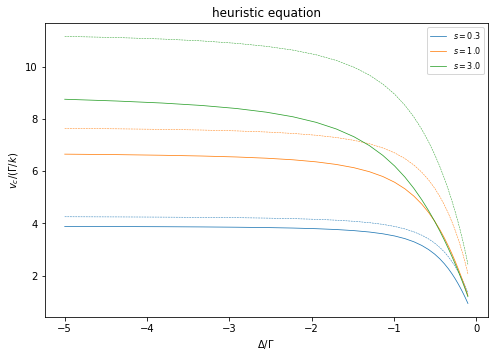

In [27]:
dets_thr = -np.logspace(-1, np.log10(5), 30)[::-1]
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for ii, (s, vc_vs_det) in enumerate(zip(intensities, it.operands[2])):
    ax.plot(dets, vc_vs_det, label='$s=%.1f$' % s,
            color='C%d'%ii, linewidth=0.75)
    ax.plot(dets_thr, vc_from_paper(dets_thr, s, mass), '--',
        color='C%d'%ii, linewidth=0.5)


ax.legend(fontsize=8)
ax.set_xlabel('$\Delta/\Gamma$')
ax.set_ylabel('$v_c/(\Gamma/k)$')
ax.set_title('heuristic equation')
fig.subplots_adjust(left=0.13, bottom=0.2)

fig.savefig('20210225_10.png')

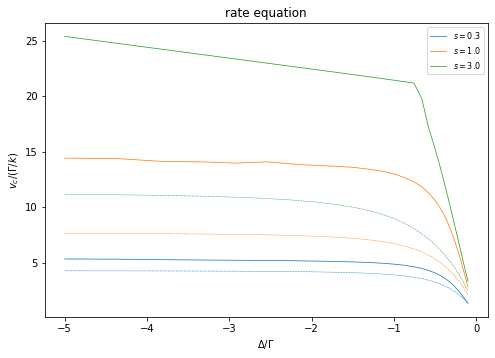

In [28]:
dets_thr = -np.logspace(-1, np.log10(5), 30)[::-1]
fig, ax = plt.subplots(1, 1, figsize=(8, 6))
for ii, (s, vc_vs_det) in enumerate(zip(intensities, it2.operands[2])):
    ax.plot(dets, vc_vs_det, label='$s=%.1f$' % s,
            color='C%d'%ii, linewidth=0.75)
    ax.plot(dets_thr, vc_from_paper(dets_thr, s, mass), '--',
            color='C%d'%ii, linewidth=0.5)

ax.legend(fontsize=8)
ax.set_xlabel('$\Delta/\Gamma$')
ax.set_ylabel('$v_c/(\Gamma/k)$')
ax.set_title('rate equation')
fig.subplots_adjust(left=0.13, bottom=0.2)

fig.savefig('20210225_11.png')